In [2]:
import warnings
from IPython.core.interactiveshell import InteractiveShell

In [3]:
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9918849346984192282
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3153238425
locality {
  bus_id: 1
  links {
  }
}
incarnation: 762573176875440235
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
# read the data

import pandas as pd
import numpy as np

data = pd.read_csv('data/neural_network_patent_query.csv', parse_dates=['patent_date'])

original_abstract = list(data['patent_abstract'])
len(original_abstract)

data.head()

3522

,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [6]:
# data exploration

data['patent_abstract'][100]

'The present invention provides an apparatus and a method for classifying and recognizing image patterns using a second-order neural network, thereby achieving high-rate parallel processing while lowering the complexity. The second-order neural network, which is made of adders and multipliers, corrects positional translations generated in a complex-log mapping unit to output the same result for the same object irrespective of the scale and/or rotation of the object. The present invention enables high-rate image pattern classification and recognition based on parallel processing, which is the advantage obtained in neural network models, because consistent neural networks and consistent network structure computation models are applied to all steps from the image input step to the pattern classifying and recognizing step.'

Text(0, 0.5, 'Number of patents')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Neural Network Patents over Time')

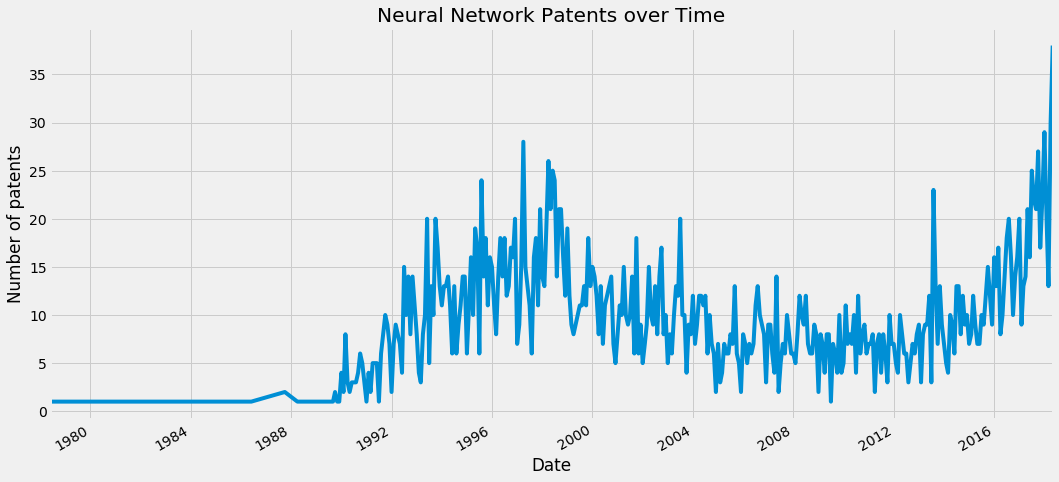

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [pd.datetime(year,month, 1) for year, month in zip(
                        data['patent_date'].dt.year, data['patent_date'].dt.month)]

monthly = data.groupby('year-month')['patent_number'].count().reset_index()

monthly.set_index('year-month')['patent_number'].plot(figsize=(16,8))

plt.ylabel('Number of patents')
plt.xlabel('Date')
plt.title('Neural Network Patents over Time')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Patents')

Text(0.5, 1.0, 'Neural Network Patents by Year')

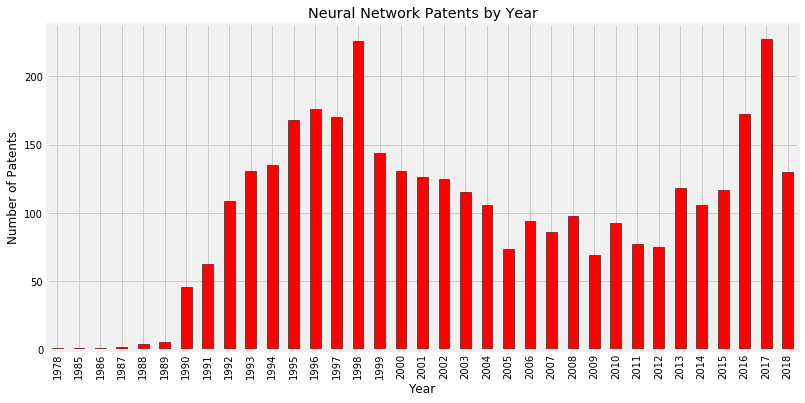

In [8]:
monthly.groupby(monthly['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12,6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

In [9]:
# data cleaning
# using a tokenizer to convert patents into a sequence of integers

from keras.preprocessing.text import Tokenizer

# removing the punctuation
example = 'This is a short sentence(1). Loving you, is both my biggest weakness and greatest strength.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s )

Using TensorFlow backend.


'this is a short sentence 1 loving you is both my biggest weakness and greatest strength'

In [10]:
print(s)

[2, 1, 3, 4, 5, 6, 7, 8, 1, 9, 10, 11, 12, 13, 14, 15]


In [11]:
# keeping the puntuation
tokenizer  = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence(1). loving you, is both my biggest weakness and greatest strength.'

dict_keys(['is', 'this', 'a', 'short', 'sentence(1).', 'loving', 'you,', 'both', 'my', 'biggest', 'weakness', 'and', 'greatest', 'strength.'])

In [12]:
# adding spaces around the punctuation using regular expression

import re

patent = ''

print(example)

def format_patent(patent):
    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)
    
     # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    
    #remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    
    return patent
    
f = format_patent(example)
print(f)


This is a short sentence(1). Loving you, is both my biggest weakness and greatest strength.
This is a short sentence . Loving you , is both my biggest weakness and greatest strength .


In [13]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([f])
s = tokenizer.texts_to_sequences([f])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence . loving you , is both my biggest weakness and greatest strength .'

dict_keys(['is', '.', 'this', 'a', 'short', 'sentence', 'loving', 'you', ',', 'both', 'my', 'biggest', 'weakness', 'and', 'greatest', 'strength'])

In [14]:
def remove_spaces(patent):
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)
    
    return patent

remove_spaces(' '.join(tokenizer.index_word[i] for i in s))

'this is a short sentence. loving you, is both my biggest weakness and greatest strength.'

In [15]:
formatted = []

for a in original_abstract:
    formatted.append(format_patent(a))

len(formatted)

3522

In [16]:
# converting text to sequences
# since neural network cannot process words so we must convert the patent abstracts into integers
# Here features will be first 50 words and 51st word will be label

def make_sequences(texts, training_length=50, lower=True, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
        tokenizer = Tokenizer(lower=lower, filters=filters)
        tokenizer.fit_on_texts(texts)
        
        word_idx = tokenizer.word_index
        idx_word = tokenizer.index_word
        num_words = len(word_idx) + 1
        word_counts = tokenizer.word_counts
        
        print(f'There are {num_words} unique words.')
        
        sequences = tokenizer.texts_to_sequences(texts)
        
        seq_lengths = [len(x) for x in sequences]
        
        over_idx = [ i for i,l in enumerate(seq_lengths) if l > (training_length + 20)]
        
        new_texts = []
        new_sequences = []
        
        for i in over_idx:
            new_texts.append(texts[i])
            new_sequences.append(sequences[i])
        
        training_seq = []
        labels = []
        
        for seq in new_sequences:
            for i in range(training_length, len(seq)):
                extract = seq[i - training_length:i + 1]
                
                training_seq.append(extract[:-1])
                labels.append(extract[-1])
        
        print(f'There are {len(training_seq)} training sequences.')
        
        return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

In [17]:
TRAINING_LENGTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(formatted, TRAINING_LENGTH, lower=True, filters=filters)

There are 13677 unique words.
There are 320881 training sequences.


In [18]:

n = 3
features[n][:10]

[3086, 1978, 11, 2, 9, 8, 19, 27, 5, 117]

In [19]:
def find_answer(index):
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]
    
    print('Features: ', feats)
    print('\nLabel: ', answer)

In [20]:
find_answer(n)

Features:  enhances stability in a neural network system that , when used as a track-while-scan system , assigns sensor plots to predicted track positions in a plot track association situation . the barometer neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a

Label:  zero


In [21]:
original_abstract[0]

'" A ""Barometer"" Neuron enhances stability in a Neural Network System that, when used as a track-while-scan system, assigns sensor plots to predicted track positions in a plot/track association situation. The ""Barometer"" Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a ""perfect"" pairing of plot and track which has a measured/desired level of inhibition. The ""Barometer"" Neuron responds to the System inputs, compares these inputs against the level of inhibition of the ""perfect"" pair, and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0; this the reference level of inhibition of the ""perfect"" pair. "'

In [22]:
find_answer(100)

Features:  it comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem , such as the number of cities to be visited . the array is prompted by analog voltages representing variables such as distances . the processor incorporates two interconnected feedback

Label:  networks


In [23]:
#Deciding which pre-processing steps to take in general is the most important aspect of an machine learning project.

In [24]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 36597),
 ('a', 24883),
 ('of', 20193),
 ('.', 16604),
 (',', 15417),
 ('and', 12947),
 ('to', 12073),
 ('network', 7733),
 ('neural', 7381),
 ('is', 7213),
 ('in', 6992),
 ('for', 6907),
 ('an', 6061),
 ('data', 4010),
 ('by', 3607)]

In [27]:
# splitting features and labels into training and validation data
# create into one-hot coded vectors 
from sklearn.utils import shuffle

def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction= TRAIN_FRACTION):
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)
    
    train_end = int(train_fraction * len(labels))
    
    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])
    
    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]
    
    X_train, X_valid = np.array(train_features), np.array(valid_features)
    
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)
    
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1
    
    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1
    
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()
    
    return X_train, X_valid, y_train, y_valid
    

In [28]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape
y_train.shape

(224616, 50)

(224616, 13677)

In [30]:
import sys
sys.getsizeof(y_train)/ 1e9

3.072073144

In [31]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB')

check_sizes(gb_min=1)

Object: y_train   	Size: 3.072073144 GB
Object: y_valid   	Size: 1.316616517 GB


In [32]:
# using pretrained embedding is much better her
# will come back after getting more thorough knowledge on this